In [2]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# from sklearn.metrics import classification_report


In [3]:
folder_name = input("Please enter the subject name: ")

Define the dataset

In [4]:
# Define the column names
column_names = ['FZ', 'FC1', 'FC2', 'C3', 'CZ', 'C4', 'CPZ', 'PZ', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']
df = []
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            df_temp = pd.read_csv(file_path, header=None)
            df.append(df_temp)     
    combined_data_array_3d = np.array(df)
    combined_data_array_2d= combined_data_array_3d.reshape(40 * 10000, 21)
    
Combined_raw_eeg = pd.DataFrame(combined_data_array_2d) 
Combined_raw_eeg.columns = column_names

#Excluding the useless columns
columns_to_remove = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Battery', 'Sample', 'Unknown','Instruction','Female/Male', 'Outdoor/Indoor', 'Human Behavior']
Combined_raw_eeg = Combined_raw_eeg.drop(columns=columns_to_remove, axis=1)

In [5]:
# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

Combined_raw_eeg_bp = np.copy(Combined_raw_eeg)
num_columns = Combined_raw_eeg_bp.shape[1]
print(num_columns)
for column in range(num_columns):
    Combined_raw_eeg_bp[:, column] = butter_bandpass_filter(Combined_raw_eeg_bp[:, column], lowcut=.4, highcut=40, fs=250)

8


In [6]:
# Pre-proccessing
# Denoising 
def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new

Combined_raw_eeg_bp=pd.DataFrame(Combined_raw_eeg_bp)
eeg_df_denoised = preprocess(Combined_raw_eeg_bp, col_names=list(Combined_raw_eeg_bp.columns), n_clusters=[50]*len(Combined_raw_eeg_bp.columns))

In [7]:
# Lableing
column_indices = {'Instruction': 17, 'Female/Male': 18, 'Outdoor/Indoor': 19}
selected_columns = [column_indices['Instruction'], column_indices['Female/Male'], column_indices['Outdoor/Indoor']]
data_im_ins = combined_data_array_2d[:, selected_columns]
denoised_im_ins = np.concatenate((eeg_df_denoised, data_im_ins), axis=1)

# Check the third last column (column 9) and keep rows if column 9 is equal to 1
filtered_denoised_im_ins = denoised_im_ins[(denoised_im_ins[:, -3] == denoised_im_ins[:, -2]) | (denoised_im_ins[:, -3] == denoised_im_ins[:, -1])]
filtered_denoised_im_ins_df = pd.DataFrame(filtered_denoised_im_ins)

# Create a new column 'event'
filtered_denoised_im_ins_df['event'] = ''
for index, row in filtered_denoised_im_ins_df.iterrows():
    if row.iloc[-4] == 'F' or row.iloc[-4] == 'M':
        filtered_denoised_im_ins_df.at[index, 'event'] = '0'
    elif row.iloc[-4] == 'I' or row.iloc[-4] == 'O':
        filtered_denoised_im_ins_df.at[index, 'event'] = '1'
        
selected_data = filtered_denoised_im_ins_df.iloc[:, :8]  
lable=filtered_denoised_im_ins_df.iloc[:, -1:]

In [8]:
f=np.array(filtered_denoised_im_ins_df)
f_d_im_ins=f.reshape(40,36, 250, 12)

In [9]:
face = []
scene = []
for i in range(len(f_d_im_ins)):
    if 'M' in f_d_im_ins[i, 0, :, 8] or 'F' in f_d_im_ins[i, 0, :, 8]:
        face.append(f_d_im_ins[i])
    else:
        scene.append(f_d_im_ins[i])
face = np.array(face)
scene = np.array(scene)

In [20]:
face_eeg_dada=face.reshape(720, 50,5, 12)
face_eeg_dada=face_eeg_dada[:,:,:,:8]
face_eeg_dada=face_eeg_dada.mean(axis=2)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)


scene_eeg_dada=scene .reshape(720, 50,5, 12)
scene_eeg_dada=scene_eeg_dada[:,:,:,:8]
scene_eeg_dada=scene_eeg_dada.mean(axis=2)
scene_mean=scene_eeg_dada.mean(axis=0)


(720, 50, 8)


In [24]:
fs=250
time_list=[]
for n in range(face_mean.shape[0]):
    time = (n*5)/(fs)
    time_list.append(time)

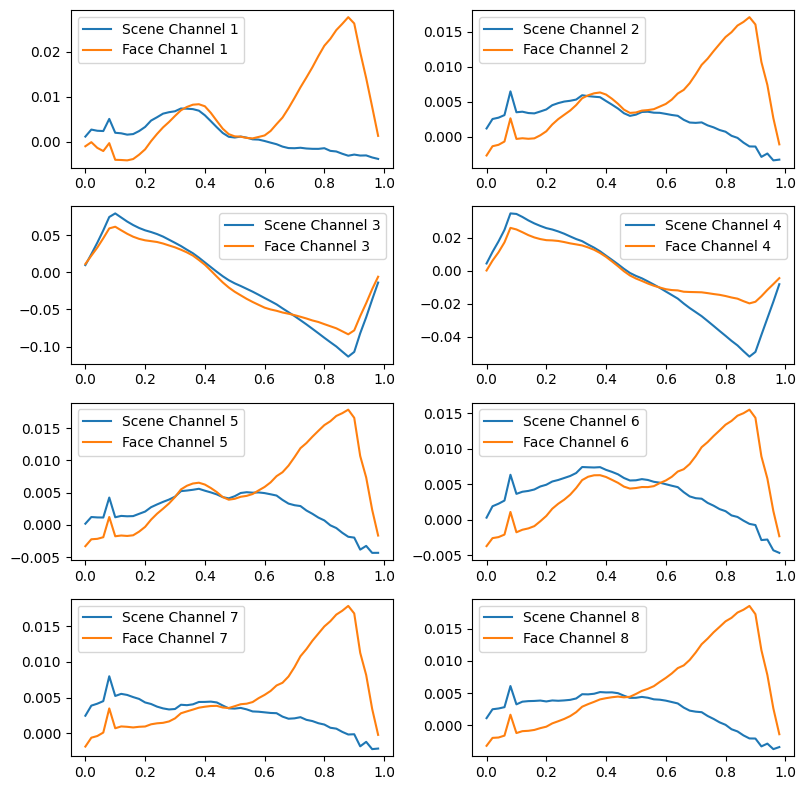

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for channel in range(8):
    plt.subplot(4, 2, channel + 1)  
    plt.plot(time_list, face_mean[:, channel], label=f'Scene Channel {channel+1}')
    plt.plot(time_list, scene_mean[:, channel], label=f'Face Channel {channel+1}')
    plt.legend()
plt.tight_layout()
plt.show()


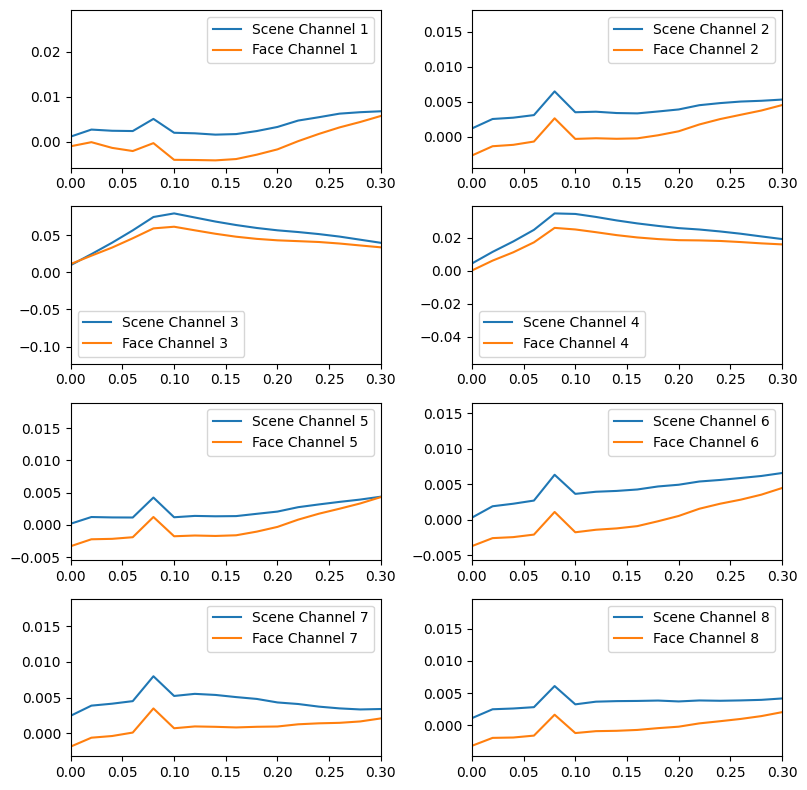

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

for channel in range(8):
    plt.subplot(4, 2, channel + 1)  # 4 rows, 2 columns, index=channel+1
    plt.plot(time_list, face_mean[:, channel], label=f'Scene Channel {channel+1}')
    plt.plot(time_list, scene_mean[:, channel], label=f'Face Channel {channel+1}')
    plt.xlim(0, 0.3)  # Limit x-axis from 0 to 0.3 (300 milliseconds)
    plt.legend()

plt.tight_layout()
plt.show()

Windowing

In [9]:
win_size = 250
X = []
y = []
for i in range(0, len(selected_data), win_size):
    window_data = selected_data.iloc[i:i+win_size]
    window_label = lable.iloc[i:i+win_size]
    X.append(window_data)
    y.append(window_label)
X = np.array(X)
y = np.array(y)
# X, y = shuffle(X, y)

In [10]:
print(X.shape, y.shape)
print(X[:,:, 7].shape)
print(X.shape[0])
print(X.shape[1])
print(X[5,:, 2].shape)

(1440, 250, 8) (1440, 250, 1)
(1440, 250)
1440
250
(250,)


In [11]:
array_3d = X.reshape(1440, 250*8)
print(array_3d.shape)
print(X.shape)
print(array_3d.shape[0])

(1440, 2000)
(1440, 250, 8)
1440


In [13]:
X.shape

(1440, 250, 8)

In [72]:
import numpy as np
from scipy.signal import welch

# Define the frequency bands
freq_bands = {'Delta': (0, 4),
              'Theta': (4, 8),
              'Alpha': (8, 13),
              'Beta': (13, 30),
              'Gamma': (30, 100)}

def get_eeg_features(eeg_data, fs):
    # Calculate the frequency spectrum using Welch's method
    freqs, psd = welch(eeg_data, fs, nperseg=fs, noverlap=fs//2)

    # Initialize a dictionary to hold the features
    features = {}

    # For each frequency band, integrate the PSD within that band
    for band, (low, high) in freq_bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        power = np.trapz(psd[idx_band], freqs[idx_band])
        # Ensure the power value is real using abs to get magnitude of complex number
        power = abs(power)
        features[band] = power

    return features

# # Your EEG data is X
# X = np.random.rand(1440, 250, 8)  # Replace this with your real EEG data

# Initialize an array to store the features
frequency_domain_features = np.empty((1440, 8, len(freq_bands)))

# Iterate over the data
for i in range(1440):  # For each image
    for k in range(8):  # For each channel
        # Extract the features
        feature_values = get_eeg_features(X[i, :, k], fs=250)
        frequency_domain_features[i, k] = list(feature_values.values())
# print(features)


In [1]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch


# Convert the data to a numerical type (float)
X = X.astype(np.float64)
print(X.shape)

# Define the size of the features
n_trials, n_samples, n_channels = X.shape
n_features = 5  # The number of time domain features we're going to compute

# Time domain features
def extract_time_domain_features(X):
    mean = np.mean(X)
    median = np.median(X)
    std_dev = np.std(X)    # Standard deviation
    skewness = skew(X)     # Skewness
    kurt = kurtosis(X)     # Kurtosis
    return [mean, median, std_dev, skewness, kurt]
# ERP features (assuming the EEG data is already aligned to the event)

def extract_erp_features(X):
    mean_amp = np.mean(X) # Mean amplitude
    peak_latency = np.argmax(X) # Peak latency (time to peak)
    peak_amp = np.max(X) # Peak amplitude
    return [mean_amp, peak_latency, peak_amp]

def extract_hilbert_features(X):
    # Compute the analytic signal, from which you can get the envelope and instantaneous phase
    analytic_signal = hilbert(X)
    # Envelope is the absolute value of the analytic signal
    envelope = np.abs(analytic_signal)
    # Mean and standard deviation of the envelope can be interesting features
    mean_envelope = np.mean(envelope)
    std_dev_envelope = np.std(envelope)
    return [mean_envelope, std_dev_envelope]
    # return envelope 

# Initialize arrays to hold the features
time_domain_features = np.zeros((n_trials, n_channels, 5)) # 5 time domain features
erp_features = np.zeros((n_trials, n_channels, 3)) # 3 ERP features
hilbert_features = np.zeros((n_trials, n_channels, 2))  # 2 Hilbert features
hilbert_features_freq=np.zeros((n_trials, n_channels, 2))
xf=np.zeros((n_trials, n_channels, 250))
# Loop over trials and channels and extract features 
for i in range(n_trials):
    for k in range(n_channels):
        time_domain_features[i, k] = extract_time_domain_features(X[i, :, k])
        erp_features[i, k] = extract_erp_features(X[i, :, k])
        hilbert_features[i, k] = extract_hilbert_features(X[i, :, k])
        hilbert_features_freq[i, k] = extract_hilbert_features(frequency_domain_features[i, :, k])
        xf[i, k]=X[i, :, k]
# Now you have time domain features and ERP features for each trial and each channel

NameError: name 'X' is not defined

In [97]:
xf.shape

(1440, 8, 250)

In [98]:
all_features = np.concatenate([time_domain_features, erp_features, hilbert_features_freq, hilbert_features, xf], axis=-1)
print(all_features.shape)

(1440, 8, 265)


In [75]:

from scipy.signal import hilbert
import scipy.signal


analytic_signal_features = hilbert(all_features)
analytic_signal_features2=hilbert(X)

# # If you want to get the absolute envelope of this analytic signal, use:
envelope_features = np.abs(analytic_signal_features)
envelope_features2 = np.abs(analytic_signal_features2)

print(envelope_features.shape)
print(envelope_features2.shape)

# print(envelope_features.shape)
# envelope=np.hstack((envelope_features, array_3d))

# feature=envelope
# # feature=envelope_features
# print(len(feature))
# feature_array=np.array(envelope_features)
# X_n=feature_array
# print(X_n.shape)


(1440, 8, 13)
(1440, 250, 8)


In [99]:
XF=all_features.reshape(1440, 8*265)

In [100]:
y_n=np.squeeze(y[:,0])
print(XF.shape, y_n.shape)

# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(XF, y_n)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_touched, y_touch, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)

(1440, 2120) (1440,)


In [101]:
# Convert one-hot-encoded labels to integer-encoded labels
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)
y_untouch = np.argmax(y_untouch, axis=-1)
print(y_train.shape, y_test.shape)

(1166,) (130,)


In [102]:
print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', X_untouch.shape, 'y_untouch:', y_untouch.shape )

X_train: (1166, 2120) y_train: (1166,) X_test: (130, 2120) y_test: (130,) X_untouch: (144, 2120) y_untouch: (144,)


In [103]:
from sklearn import svm
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)
# Save the model to disk
filename = 'C:/Users/tnlab/OneDrive/Documents/GitHub/Neurofeedback-Based-BCI/SVM for Unicorn Data/my_svm_model.joblib'
dump(clf, filename)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)

report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)

Model accuracy:  0.6384615384615384
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63        66
           1       0.62      0.67      0.65        64

    accuracy                           0.64       130
   macro avg       0.64      0.64      0.64       130
weighted avg       0.64      0.64      0.64       130



In [ ]:
# Hilbert feature extraction and PCA data Reduction
import numpy as np

from scipy.signal import hilbert
import scipy.signal


# Frequencies
delta = (0.5, 4)
theta = (4, 8)
alpha = (8, 13)
beta = (13, 30)
gamma = (30, 45)
freq_bands = [delta, theta, alpha, beta, gamma]
# Loop over your array_3d data
features = []
for i in range(array_3d.shape[0]):  # iterating over the first dimension
    # FFT on your data
    freqs, psd = scipy.signal.welch(array_3d[i])
    # Loop over the frequency bands and save power from each band
    band_power = []
    for band in freq_bands:
        idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
        power = sum(psd[idx_band])
        band_power.append(power)
    features.append(band_power)
features = np.array(features)
print(features.shape)
real_features = np.abs(features)

analytic_signal_features = hilbert(real_features)
analytic_signal_features2=hilbert(array_3d)

# # If you want to get the absolute envelope of this analytic signal, use:
envelope_features = np.abs(analytic_signal_features)
envelope_features2 = np.abs(analytic_signal_features2)

print(envelope_features.shape)
envelope=np.hstack((envelope_features, array_3d))

feature=envelope
# feature=envelope_features
print(len(feature))
feature_array=np.array(feature)
X_n=feature_array
print(X_n.shape)
